In [3]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
# !sudo pip3 install keras

# def get_default_device():
#     """Picking GPU if available or else CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')

# device = get_default_device()


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))


Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [5]:
# Variables for pre-processing and training.
batch_size = 32
epochs = 70
IMG_HEIGHT = 150
IMG_WIDTH = 150

print(f"Train images: {total_train}")
print(f"Validation images: {total_val}")
print(f"Test images: {total_test}")
print(test_dir)

Train images: 2001
Validation images: 1001
Test images: 51
cats_and_dogs/test


In [6]:
# 3
train_image_generator = ImageDataGenerator(
                        rescale= 1./255)
validation_image_generator = ImageDataGenerator(
                        rescale= 1./255)
test_image_generator = ImageDataGenerator(
                        rescale= 1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           target_size= (IMG_HEIGHT, IMG_WIDTH),
                                                           batch_size= batch_size,
                                                           class_mode= 'binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size= (IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size= batch_size,
                                                              class_mode= 'binary')
test_data_gen = test_image_generator.flow_from_directory(directory= './cats_and_dogs',target_size= (IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size=batch_size,
                                                         shuffle= False,
                                                         class_mode='binary', classes=['test'])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


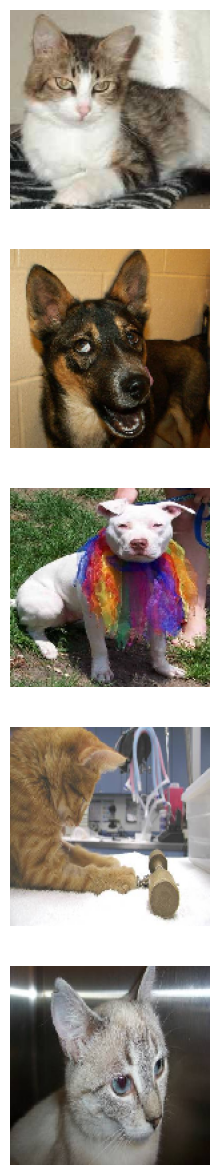

In [7]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [8]:
# 5
train_image_generator = ImageDataGenerator(rescale= 1.0/255,
                                           rotation_range= 40,
                                           height_shift_range=0.2,
                                           width_shift_range= 0.2,
                                           shear_range= 0.3,
                                           zoom_range=0.3,
                                           horizontal_flip= True,
                                           fill_mode='nearest')


Found 2000 images belonging to 2 classes.


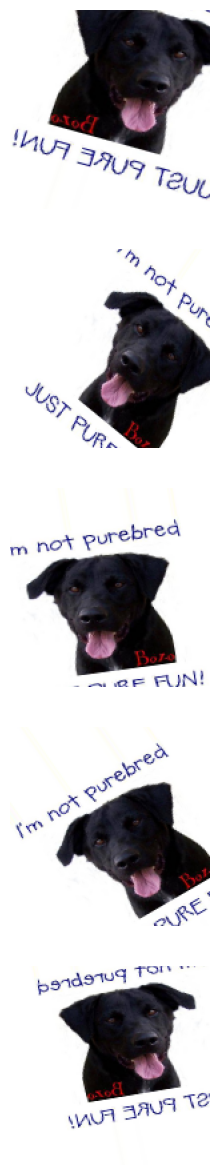

In [13]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [30]:
# 7
model = Sequential(
  [Conv2D(32, kernel_size=3, activation= 'relu', input_shape=(IMG_HEIGHT, IMG_WIDTH,3)),
   MaxPooling2D((2,2)),
  Conv2D(64, kernel_size=3, activation='relu'),
   MaxPooling2D((2,2)),
  Conv2D(64, kernel_size=3, activation='relu'),
   MaxPooling2D((2,2)),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(1, activation='sigmoid')]
)

# with tpu_strategy.scope():
# model = Sequential (
#     [
#         Conv2D(96, kernel_size=11, activation='relu', strides=4, input_shape=(IMG_HEIGHT, IMG_WIDTH,3)),
#         MaxPooling2D((3,3), strides=2),
#         Conv2D(256, kernel_size= 5, strides=4, activation='relu', padding='same'),
#         MaxPooling2D((3,3), strides=2),
#         Conv2D(384, kernel_size= 3, strides=4, padding='same', activation='relu'),
#         Conv2D(384, kernel_size= 3, strides=4, padding='same', activation='relu'),
#         Conv2D(256, kernel_size= 3, strides=4, padding='same', activation='relu'),
#         # MaxPooling2D((3,3), strides
#         Flatten(),
#         Dense(4096, activation='relu'),
#         Dropout(rate=0.5),
#         Dense(4096, activation='relu'),
#         Dropout(rate=0.5),
#         Dense(1, activation='sigmoid')
#     ]
# )

# model=Sequential()
# model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
# model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
# model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
# model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dense(4096,activation="relu"))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dense(1000,activation="relu"))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dense(20,activation="softmax"))

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer= optimizer,
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 17, 17, 64)       

In [31]:
# 8
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.0001)
# model.fit(X_train, Y_train, callbacks=[reduce_lr])

history = model.fit(train_data_gen, epochs=epochs,
                    steps_per_epoch= len(train_data_gen),
                    validation_data= val_data_gen,
                    validation_steps= len(val_data_gen))

Epoch 1/70
63/63 [==============================] - 18s 251ms/step - loss: 0.7143 - accuracy: 0.5135 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/70
63/63 [==============================] - 15s 243ms/step - loss: 0.6935 - accuracy: 0.5075 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/70
63/63 [==============================] - 15s 234ms/step - loss: 0.6932 - accuracy: 0.5130 - val_loss: 0.6895 - val_accuracy: 0.5720
Epoch 4/70
63/63 [==============================] - 15s 234ms/step - loss: 0.6926 - accuracy: 0.5485 - val_loss: 0.6860 - val_accuracy: 0.5650
Epoch 5/70
63/63 [==============================] - 15s 234ms/step - loss: 0.6877 - accuracy: 0.5490 - val_loss: 0.6799 - val_accuracy: 0.6170
Epoch 6/70
63/63 [==============================] - 15s 231ms/step - loss: 0.6848 - accuracy: 0.5540 - val_loss: 0.6716 - val_accuracy: 0.5800
Epoch 7/70
63/63 [==============================] - 15s 233ms/step - loss: 0.6816 - accuracy: 0.5550 - val_loss: 0.6721 - val_accuracy: 0.5940

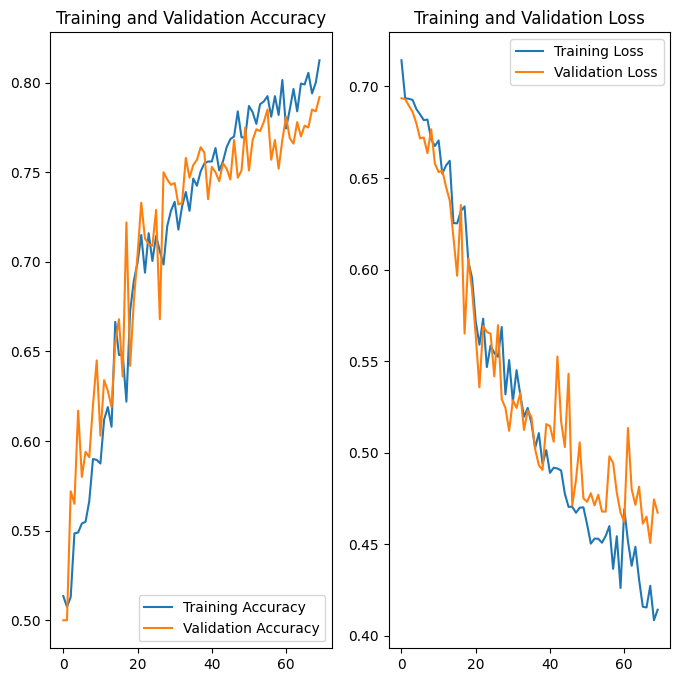

In [32]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
predictions= model.predict(test_data_gen, verbose=True).flatten()
predictions
probabilities= predictions

2/2 [==============================] - 0s 316ms/step


In [34]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 80.0% of the images of cats and dogs.
You passed the challenge!
